In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import os

from tqdm import trange

import numpy as np
from scipy.stats import sem

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from modules.models.baselines import static_stat_forecast, rolling_stat_forecast, ewm_forecast
from modules.diagnostics.visualizers import visualize_forecast_horizon_accuracy, visualize_time_series
from modules.diagnostics.metrics import compute_rmse
from modules.data_handling.data_splitters import split_time_series_df, tabularize_time_series

# Constants

In [5]:
TRAINING_END_DATE = "2016-01-01"

DATA_FOLDER = "data"
GHI_FILE = "irradiance.csv"
WEATHER_FORECAST_FILES = [
    "nam_lat38.579454_lon121.260320.csv"
]
SATELLITE_FILE = "satellite.csv"

# Data Loading

In [6]:
ghi_df = pd.read_csv(os.path.join(DATA_FOLDER, GHI_FILE), parse_dates=["timeStamp"])
# We ensure ghi data are continuous
idx = pd.date_range(ghi_df["timeStamp"].min(), ghi_df["timeStamp"].max(), freq="1min")
ghi_df = ghi_df.set_index("timeStamp") 
ghi_df = (
    ghi_df
    .reindex(idx, fill_value=np.nan)
    .interpolate("linear")
)

ghi_df = (
    ghi_df
    .reset_index()
    .rename({"index": "time"}, axis=1)
)

In [7]:
weather_df

[]

In [8]:
weather_df = []
for weather_forecast_file in WEATHER_FORECAST_FILES:
    
    weather_df.append(
        pd.read_csv(os.path.join(DATA_FOLDER, weather_forecast_file), parse_dates=["reftime", "valtime"])
        .dropna()
    )
    
weather_df = pd.concat(weather_df, ignore_index=True)

In [131]:
saletllite_df = pd.read_csv(os.path.join(DATA_FOLDER, SATELLITE_FILE), header=None, parse_dates=[0])
idx = pd.date_range(saletllite_df[0].min(), saletllite_df[0].max(), freq="15min")
saletllite_df = saletllite_df.set_index(0) 
saletllite_df = (
    saletllite_df
    .reindex(idx, fill_value=np.nan)
    .interpolate("nearest")
)

saletllite_df = (
    saletllite_df
    .reset_index()
    .rename({"index": "time"}, axis=1)
)

# Data Exploration

## GHI Data

In [132]:
ghi_df.describe()

,time,ghi,dni,dhi
count,1575360,1.575360e+06,1.575360e+06,1.575360e+06
mean,2015-07-03 07:59:30.000004096,2.054944e+02,2.560642e+02,5.345318e+01
min,2014-01-02 08:00:00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2014-10-02 19:59:45,0.000000e+00,0.000000e+00,0.000000e+00
50%,2015-07-03 07:59:30,1.280000e+00,0.000000e+00,2.509500e+00
75%,2016-04-01 19:59:15,3.788000e+02,6.538000e+02,7.873000e+01
max,2016-12-31 07:59:00,1.466000e+03,1.004000e+03,7.481000e+02
std,NaN,2.942295e+02,3.618388e+02,8.394639e+01


In [133]:
ghi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1575360 entries, 0 to 1575359
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   time    1575360 non-null  datetime64[ns]
 1   ghi     1575360 non-null  float64       
 2   dni     1575360 non-null  float64       
 3   dhi     1575360 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 48.1 MB


In [134]:
# Very relevant
ghi_df["month"] = ghi_df["time"].dt.month
ghi_df["day_year"] = ghi_df["time"].dt.day_of_year
ghi_df["hour"] = ghi_df["time"].dt.hour

# Spurious, these should come out irrelevant if there is no bias in the measurement
ghi_df["year"] = ghi_df["time"].dt.year
ghi_df["day_week"] = ghi_df["time"].dt.day_of_week
ghi_df["minute"] = ghi_df["time"].dt.minute

In [135]:
# We execpt at least 525600 datapoints if data are recorded continuously for 3 years
(
    ghi_df
    .groupby("year")
    .size()
)

year
2014    523680
2015    525600
2016    526080
dtype: int64

/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/penthotal/mambaforge-pypy3/envs/ghi_forecast_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

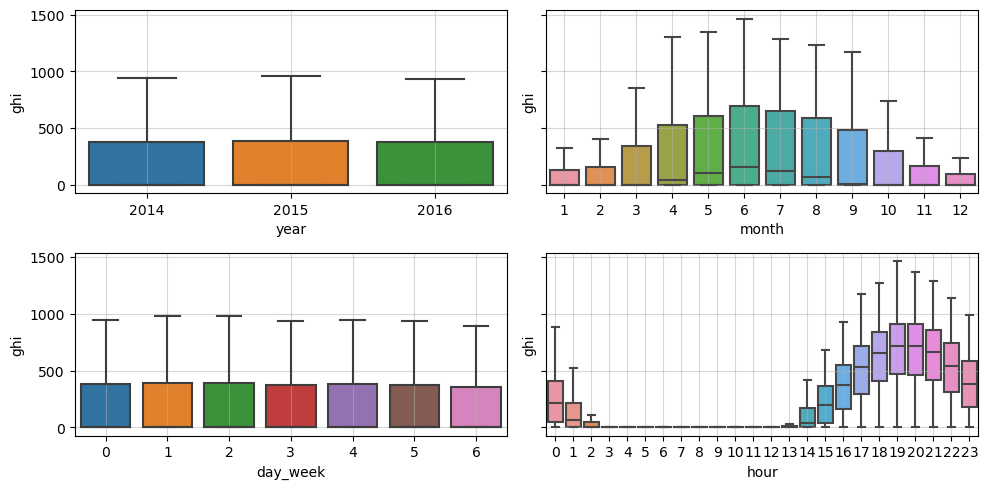

In [136]:
groupers = [
    "year",
    "month",
    "day_week",
    "hour"
]
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey=True)

for ax, grouper in zip(axs.flatten(), groupers):

    sns.boxplot(
        data=ghi_df,
        x=grouper,
        y="ghi",
        showfliers=False,
        ax=ax
    )
    ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()

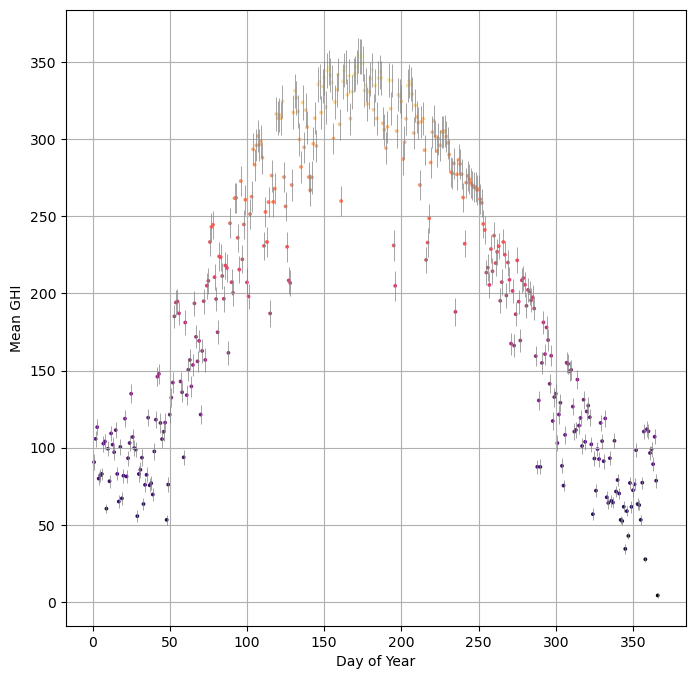

In [137]:
dayly_stats = (
    ghi_df
    .groupby("day_year")
    .agg(
        mean=("ghi", "mean"),
        std_err_mean=("ghi", lambda x: sem(x))
    )
    .reset_index()
    
)

plt.figure(figsize=(8, 8))
plt.scatter(
    x=dayly_stats["day_year"].values,
    y=dayly_stats["mean"].values,
    s=3,
    c=dayly_stats["mean"].values,
    cmap="magma"
)
plt.errorbar(
    x=dayly_stats["day_year"].values,
    y=dayly_stats["mean"].values,
    yerr=dayly_stats["std_err_mean"].values * 1.96,
    linewidth=0.5,
    ls='none',
    c="grey"

)
plt.ylabel("Mean GHI")
plt.xlabel("Day of Year")
plt.grid()

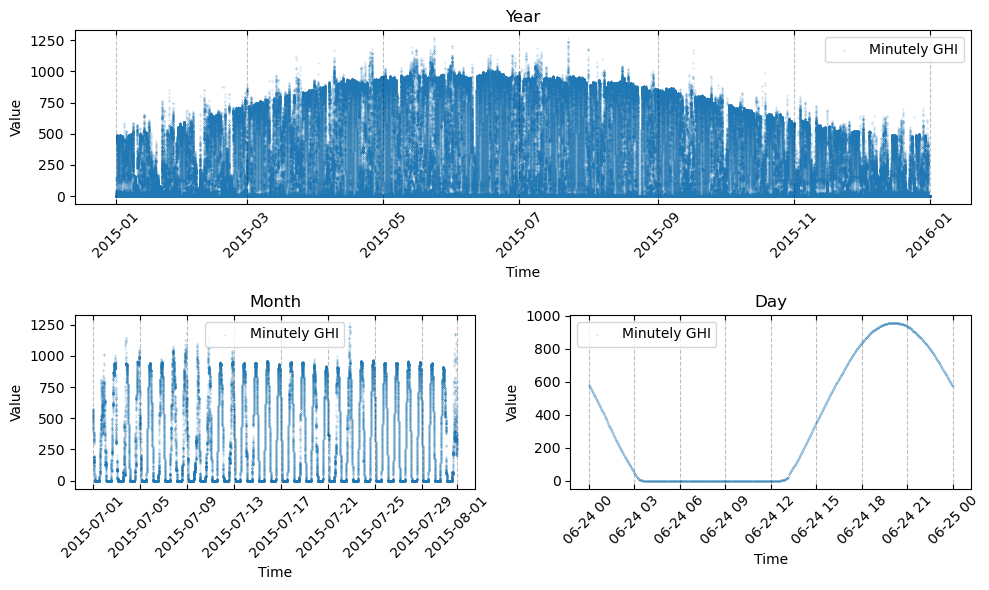

In [178]:
single_year_ghi_df = ghi_df[ghi_df["year"] == 2015]
single_month_ghi_df = ghi_df[(ghi_df["year"] == 2015) & (ghi_df["month"] == 7)]
single_day_ghi_df = ghi_df[(ghi_df["year"] == 2015) & (ghi_df["day_year"] == 175)]

fig = plt.figure(figsize=(10, 6), tight_layout=True)
gs = gridspec.GridSpec(2, 2)

ax_year = fig.add_subplot(gs[0, :])
ax_month = fig.add_subplot(gs[1, 0])
ax_day = fig.add_subplot(gs[1, 1])


axes_dfs = {
   "Year": (ax_year, single_year_ghi_df),
   "Month": (ax_month, single_month_ghi_df),
   "Day": (ax_day, single_day_ghi_df)

}

for title, (ax, df) in axes_dfs.items():

    ax = visualize_time_series(
        ax=ax,
        time_index=df["time"],
        time_series_name="Minutely GHI",
        time_series=df["ghi"],
        s=0.05,
        alpha=0.5
    )
    ax.set_title(title)
    ax.legend()

## Satellite Data

In [138]:
saletllite_df.head(5)

,time,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,2014-03-13 18:00:00,77.0,76.0,77.0,77.0,84.0,82.0,79.0,76.0,74.0,...,77.0,76.0,75.0,74.0,76.0,76.0,76.0,77.0,77.0,78.0
1,2014-03-13 18:15:00,77.0,76.0,77.0,77.0,84.0,82.0,79.0,76.0,74.0,...,77.0,76.0,75.0,74.0,76.0,76.0,76.0,77.0,77.0,78.0
2,2014-03-13 18:30:00,79.0,77.0,76.0,75.0,89.0,79.0,76.0,74.0,67.0,...,81.0,82.0,80.0,76.0,79.0,78.0,77.0,76.0,77.0,78.0
3,2014-03-13 18:45:00,79.0,77.0,76.0,75.0,89.0,79.0,76.0,74.0,67.0,...,81.0,82.0,80.0,76.0,79.0,78.0,77.0,76.0,77.0,78.0
4,2014-03-13 19:00:00,81.0,80.0,79.0,78.0,86.0,81.0,83.0,80.0,68.0,...,78.0,79.0,78.0,76.0,79.0,79.0,79.0,79.0,80.0,81.0


In [139]:
saletllite_df.describe()

,time,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
count,98327,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,...,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000,98327.000000
mean,2015-08-07 20:45:00.000000512,104.673986,104.354572,104.089691,103.965279,104.878446,104.323492,103.427512,103.123059,102.464542,...,104.924680,105.412308,105.496273,105.406287,106.677362,107.025151,107.638289,108.432760,109.142657,109.312457
min,2014-03-13 18:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2014-11-24 19:22:30,82.000000,81.000000,81.000000,80.000000,82.000000,82.000000,81.000000,80.000000,79.000000,...,82.000000,83.000000,83.000000,83.000000,85.000000,85.000000,86.000000,88.000000,89.000000,89.000000
50%,2015-08-07 20:45:00,95.000000,94.000000,94.000000,93.000000,95.000000,95.000000,95.000000,95.000000,93.000000,...,95.000000,95.000000,96.000000,96.000000,97.000000,97.000000,98.000000,99.000000,100.000000,101.000000
75%,2016-04-19 22:07:30,117.000000,117.000000,117.000000,116.000000,116.000000,116.000000,115.000000,115.000000,115.000000,...,117.000000,117.000000,117.000000,117.000000,117.000000,117.000000,118.000000,118.000000,119.000000,119.000000
max,2016-12-31 23:30:00,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
std,NaN,31.515204,31.803811,31.878095,32.076861,31.736400,32.138111,32.745757,32.914638,33.090754,...,31.432413,31.217330,31.298630,31.428878,30.567715,30.247307,29.893872,29.529785,29.328337,29.243425


In [140]:
saletllite_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98327 entries, 0 to 98326
Columns: 101 entries, time to 100
dtypes: datetime64[ns](1), float64(100)
memory usage: 75.8 MB


In [141]:
saletllite_df["year"] = saletllite_df["time"].dt.year
(
    saletllite_df
    .groupby("year")
    .size()
)

year
2014    28152
2015    35040
2016    35135
dtype: int64

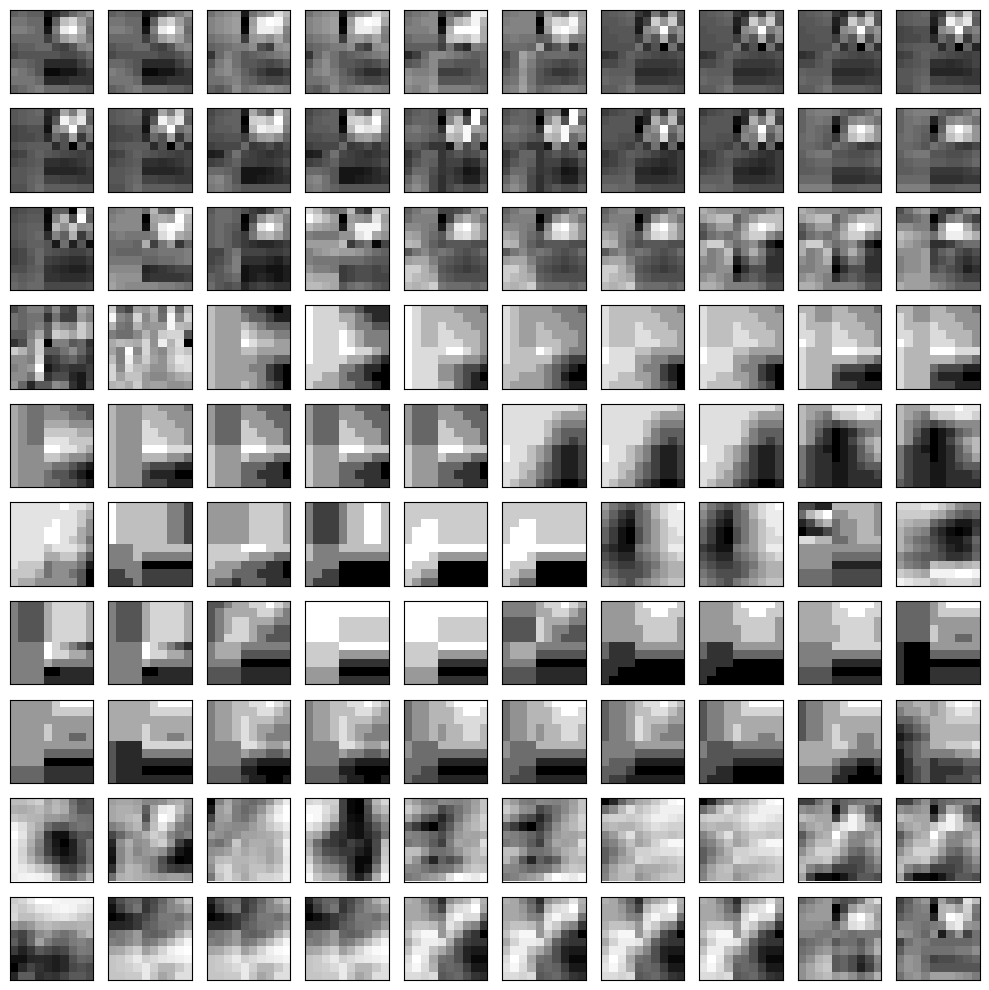

In [142]:
fig, axs = plt.subplots(10, 10, figsize=(10, 10), sharex=True, sharey=True)

for row, ax in enumerate(axs.flatten()):

    satellite_img = saletllite_df.loc[row, :][np.arange(1, 101)].values.astype("float")
    satellite_img = satellite_img.reshape(10, 10)

    ax.imshow(satellite_img, cmap="binary")

    ax.set_yticks([])
    ax.set_xticks([])

plt.tight_layout()
plt.show()


## Forecast Data

# Data Preparation II

## GHI Data

# Modelling

## Modelling Data Preparation

In [143]:
insample_ghi_df, outsample_ghi_df = split_time_series_df(
    df=ghi_df,
    start_date=TRAINING_END_DATE,
    time_column="time"
)

## Baseline I - Mean Persistence Model

In [184]:
mean_persistence_model = (
    insample_ghi_df
    .groupby(["day_year", "hour", "minute"])
    ["ghi"]
    .mean()
    .reset_index()
    .rename({"ghi": "ghi_forecast"}, axis=1)
)

mean_persistence_forecast = (
    pd.merge(
        outsample_ghi_df,
        mean_persistence_model,
        how="left",
        on=["day_year", "hour", "minute"]
    )
    [["ghi", "ghi_forecast"]]
)


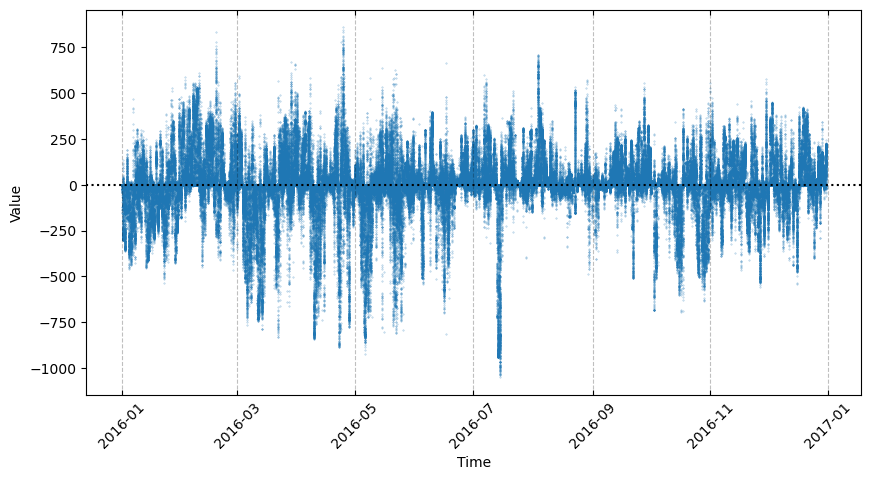

In [189]:
residual = mean_persistence_forecast["ghi"] - mean_persistence_forecast["ghi_forecast"]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax = visualize_time_series(
    ax=ax,
    time_index=outsample_ghi_df["time"],
    time_series=residual.values,
    time_series_name="Residuals",
    s=0.1,
    alpha=0.5
)
ax.axhline(
    y=0,
    linestyle=":",
    c="k"
)
plt.show()

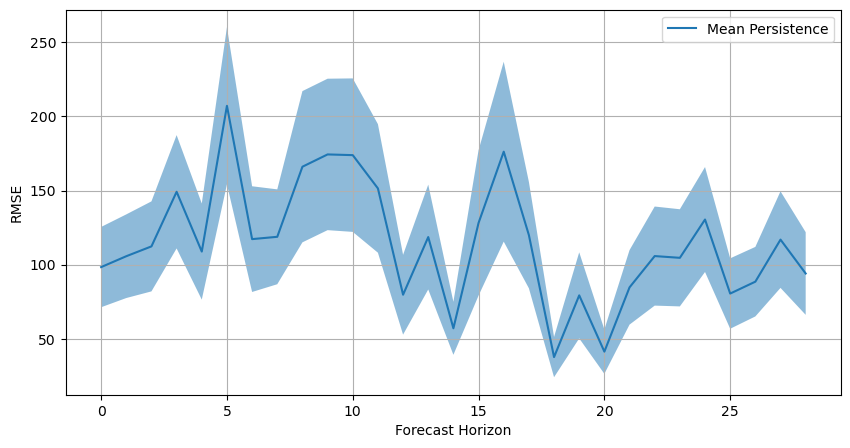

In [190]:
y_true = np.array(np.split(mean_persistence_forecast["ghi"].values, 30)).T
y_forecast = np.array(np.split(mean_persistence_forecast["ghi_forecast"].values, 30)).T

error_mean, error_sem = compute_rmse(
    y_true=y_true,
    y_forecast=y_forecast,
    axis=0
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Mean Persistence",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem
)
plt.legend()
plt.show()

## Baseline II - Exponential Moving Average

In [72]:
start_date = pd.to_datetime(TRAINING_END_DATE)

ground_truth = []
forecasts = []

for step in trange(5000):

    insample_df, outsample_df = split_time_series_df(
        df=ghi_df,
        start_date=start_date,
        time_column="time",
        steps_ahead=30,
        resolution="m"
    )

    start_date += pd.to_timedelta(30, unit="m")

    insample_series = insample_df["ghi"].values
    outsample_series = outsample_df["ghi"].values

    insample_forecast, outsample_forecast = ewm_forecast(
        time_series=insample_series,
        steps_ahead=30,
        alpha=0.5,
    )

    ground_truth.append(outsample_series)
    forecasts.append(outsample_forecast)

ground_truth = np.array(ground_truth)
forecasts = np.array(forecasts)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [09:59<00:00,  8.34it/s]


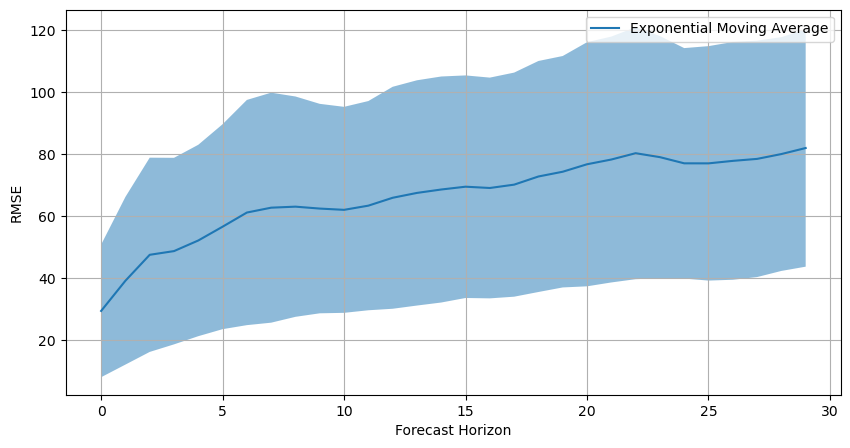

In [74]:
error_mean, error_sem = compute_rmse(
    y_true=ground_truth,
    y_forecast=forecasts,
    axis=0
)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = visualize_forecast_horizon_accuracy(
    ax=ax,
    model_name="Exponential Moving Average",
    error_name="RMSE",
    error_mean=error_mean,
    error_sem=error_sem
)
plt.legend()
plt.show()

## Baseline III - Multi Seasonal Decomposition

In [43]:
from modules.models.neural_networks.architectures import LinearModel, MLPModel
from torch.utils.data import DataLoader, TensorDataset
from torch import Tensor


model = MLPModel(
    10,
    2,
    (10, 10, 10),
    "ReLU",
    "ReLU",
    0.1
    
)

X = np.random.random(size=(10000, 10)).astype("float32")
data = TensorDataset(
   Tensor(X),
   Tensor(X)
)
loader = DataLoader(
    data,
    batch_size=256
)
for batch in loader:

    X, y = batch
    yhat =  model.forward(X)

In [42]:
batch

[tensor([[0.3009, 0.7599, 0.3581,  ..., 0.3291, 0.5120, 0.4158],
         [0.5376, 0.0547, 0.5371,  ..., 0.5306, 0.1729, 0.5929],
         [0.9694, 0.6329, 0.1772,  ..., 0.2011, 0.4011, 0.1072],
         ...,
         [0.8571, 0.9580, 0.7746,  ..., 0.5713, 0.0405, 0.8157],
         [0.3743, 0.9568, 0.3483,  ..., 0.7165, 0.7579, 0.5031],
         [0.9952, 0.6334, 0.6859,  ..., 0.2034, 0.4168, 0.0880]]),
 tensor([[0.3009, 0.7599, 0.3581,  ..., 0.3291, 0.5120, 0.4158],
         [0.5376, 0.0547, 0.5371,  ..., 0.5306, 0.1729, 0.5929],
         [0.9694, 0.6329, 0.1772,  ..., 0.2011, 0.4011, 0.1072],
         ...,
         [0.8571, 0.9580, 0.7746,  ..., 0.5713, 0.0405, 0.8157],
         [0.3743, 0.9568, 0.3483,  ..., 0.7165, 0.7579, 0.5031],
         [0.9952, 0.6334, 0.6859,  ..., 0.2034, 0.4168, 0.0880]])]